# Assign RegulatoryOverlayUUIDs Values to Water Right sites.csv
Purpose:  To assign RegulatoryOverlayUUIDs values to state water right sites.csv File.

Notes: 
- requires the completed pre-processed sites.csv & watersource.csv files from the state "WaterAllocation/ProcessedInputData" folder to be copied over to the "Regulatory/ProcessedInputData" folder.  Rename to wr_sites.csv & wr_watersource.csv to preserve inputs.
- requires awareness of unique WaterSourceTypeCV of each water right site match up to corresponding WaterSourceTypeCV of regulatoryoverlays per reportingunits

In [1]:
# Needed Libraries / Modules

# ---- working with data ----
import os  # native operating system interaction
import numpy as np  # mathematical array manipulation
import pandas as pd  # data structure and data analysis
import geopandas as gpd  # geo-data structure and data analysis

# ---- visualization ----
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # plotting library
import geoplot as gplt # for plotting maps
import geoplot.crs as gcrs #used to pull in webdata

# ---- API data retrieval ----
import requests  # http requests
import json  # JSON parse

# ---- Cleanup ----
import re  # string regular expression manipulation
from datetime import datetime  # date and time manipulation
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppress scientific notation in Pandas

In [2]:
# ---- working directory ----
workingDirString = "G:/Shared drives/WaDE Data/Arizona/Regulatory" # set working directory folder string here
os.chdir(workingDirString)
print(f'The working Directory is:', workingDirString)

The working Directory is: G:/Shared drives/WaDE Data/Arizona/Regulatory


## Input Data

In [3]:
# Regulatory Input Data
dfro = pd.read_csv("ProcessedInputData/regulatoryoverlays.csv")
dfru = pd.read_csv("ProcessedInputData/reportingunits.csv")
dfrru = pd.read_csv("ProcessedInputData/regulatoryreportingunits.csv")

# Water right Input Data
dfws = pd.read_csv('ProcessedInputData/wr_watersources.csv')
dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', engine = "python",encoding = "ISO-8859-1", on_bad_lines = 'skip')

In [4]:
#### regulatory watersource info with reporting unit info

# merge regulatoryoverlays -to- regulatoryreportingunits -to- reportingunits
dfro = pd.merge(dfro[['RegulatoryOverlayUUID', 'WaterSourceTypeCV']], dfrru[['RegulatoryOverlayUUID', 'ReportingUnitUUID']], left_on='RegulatoryOverlayUUID', right_on='RegulatoryOverlayUUID', how='left')
dfru = pd.merge(dfru, dfro, left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')

print(dfru['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfru))
dfru.head(1)

['Groundwater']
8


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,AZre_RUaz1,4326,SANTA CRUZ AMA,az1,NaN,Active Management Areas,1/10/2023,AZ,POLYGON ((-111.19920647185997 31.8582010611542...,AZre_ROaz1,Groundwater


In [5]:
#### water right watersource info with site info

# explode site.csv on WaterSourceUUIDs
dfs = dfs.assign(WaterSourceUUIDs=dfs['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)

# merge watersources to dfs via WaterSourceUUIDs -to -WaterSourceUUID
dfs = pd.merge(dfs, dfws[['WaterSourceUUID', 'WaterSourceTypeCV']], left_on='WaterSourceUUIDs', right_on='WaterSourceUUID', how='left')
print(dfs['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfs))
dfs.head(1)

['Groundwater' 'Surface Water']
203085


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,AZwr_SPODA01001001BAB,NaN,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,NaN,NaN,NaN,NaN,33.46482,-112.21531,NaN,NaN,POD,WaDE Blank,PODA01001001BAB,NaN,Well,AZ,NaN,AZwr_WSwadeID1,Groundwater


## Extract RegulatoryOverlay from Reporting Units and assing to WR Sites
- repeat scripts based on the number of ReportingUnitTypeCV types.
- merge all geo-dataframes into one output

#### Regulatory Area Data #1

In [6]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru1 = dfru.copy()
nameOfReportingUnitTypeVar = "Active Management Areas" # change here for ReportingUnitTypeCV of interest
dfru1 = dfru1[dfru1['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru1))
print(dfru1['WaterSourceTypeCV'].unique())
dfru1.head(1)

5
['Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,AZre_RUaz1,4326,SANTA CRUZ AMA,az1,NaN,Active Management Areas,1/10/2023,AZ,POLYGON ((-111.19920647185997 31.8582010611542...,AZre_ROaz1,Groundwater


<GeoAxesSubplot: >

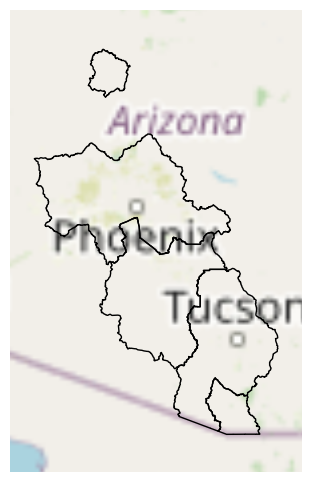

In [7]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru1 = dfru1[dfru1['Geometry'] != ""].reset_index(drop=True)
dfru1['Geometry'] = gpd.GeoSeries.from_wkt(dfru1['Geometry'], crs="EPSG:4326")
gdfru1 = gpd.GeoDataFrame(dfru1, geometry=dfru1['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru1, ax=ax)

In [8]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs1 = dfs.copy()
nameOfWaterSourceTypeCV= "Groundwater" # change here for WaterSourceTypeCV of interest
dfs1 = dfs1[dfs1['WaterSourceTypeCV'] == nameOfWaterSourceTypeCV]
dfs1 = dfs1[dfs1['PODorPOUSite'] == 'POD']
print(len(dfs1))
print(dfs1['WaterSourceTypeCV'].unique())
dfs1.head(1)

123976
['Groundwater']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,AZwr_SPODA01001001BAB,NaN,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,NaN,NaN,NaN,NaN,33.46482,-112.21531,NaN,NaN,POD,WaDE Blank,PODA01001001BAB,NaN,Well,AZ,NaN,AZwr_WSwadeID1,Groundwater


<GeoAxesSubplot: >

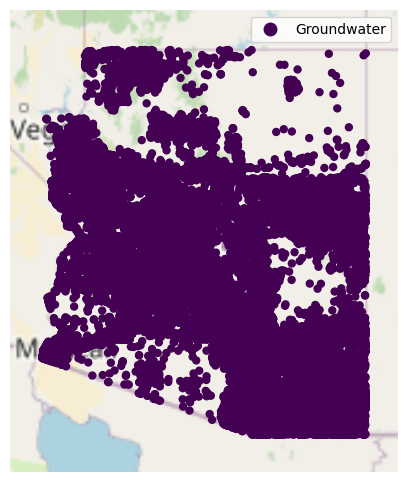

In [9]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs1 = gpd.GeoDataFrame(dfs1, geometry=gpd.points_from_xy(dfs1.Longitude.astype(float), dfs1.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [10]:
# Select sites within polygon.
gdfs1_ru1 = gpd.sjoin(left_df=gdfs1, right_df=gdfru1[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs1_ru1))
gdfs1_ru1.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


47323


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
0,AZwr_SPODA01001001BAB,,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,,,,,33.46482,-112.21531,,,POD,WaDE Blank,PODA01001001BAB,,Well,AZ,,AZwr_WSwadeID1,Groundwater,POINT (-112.21531 33.46482),2,AZre_RUaz5,AZre_ROaz5
1,AZwr_SPODA01001001BCB,,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,,,,,33.46127,-112.21972,,,POD,WaDE Blank,PODA01001001BCB,,Well,AZ,,AZwr_WSwadeID1,Groundwater,POINT (-112.21972 33.46127),2,AZre_RUaz5,AZre_ROaz5
2,AZwr_SPODA01001001BDC,,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,,,,,33.45954,-112.21538,,,POD,WaDE Blank,PODA01001001BDC,,Well,AZ,,AZwr_WSwadeID1,Groundwater,POINT (-112.21538 33.45954),2,AZre_RUaz5,AZre_ROaz5
3,AZwr_SPODA01001001CAA,,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,,,,,33.45778,-112.21323,,,POD,WaDE Blank,PODA01001001CAA,,Well,AZ,,AZwr_WSwadeID1,Groundwater,POINT (-112.21323 33.45778),2,AZre_RUaz5,AZre_ROaz5
4,AZwr_SPODA01001001CBB,,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,,,,,33.45778,-112.21978,,,POD,WaDE Blank,PODA01001001CBB,,Well,AZ,,AZwr_WSwadeID1,Groundwater,POINT (-112.21978 33.45778),2,AZre_RUaz5,AZre_ROaz5


<GeoAxesSubplot: >

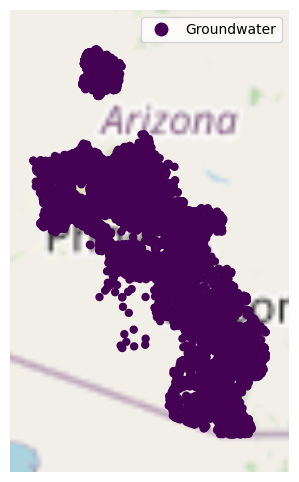

In [11]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs1_ru1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [12]:
# set RegulatoryOverlayUUIDs
gdfs1_ru1['RegulatoryOverlayUUIDs'] = gdfs1_ru1['RegulatoryOverlayUUID']
gdfs1_ru1 = gdfs1_ru1.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs1_ru1.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
0,AZwr_SPODA01001001BAB,AZre_ROaz5,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,,,,,33.46482,-112.21531,,,POD,WaDE Blank,PODA01001001BAB,,Well,AZ,


#### Regulatory Area Data #2

In [13]:
# dfru2 = dfru.copy()
# etc etc

In [14]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru2 = dfru.copy()
nameOfReportingUnitTypeVar = "Irrigation Non-Expansion Areas" # change here for ReportingUnitTypeCV of interest
dfru2 = dfru2[dfru2['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru2))
print(dfru2['WaterSourceTypeCV'].unique())
dfru2.head(1)

3
['Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
2,AZre_RUaz3,4326,HARQUAHALA INA,az3,NaN,Irrigation Non-Expansion Areas,1/10/2023,AZ,POLYGON ((-113.30171877245296 33.8349369910477...,AZre_ROaz3,Groundwater


<GeoAxesSubplot: >

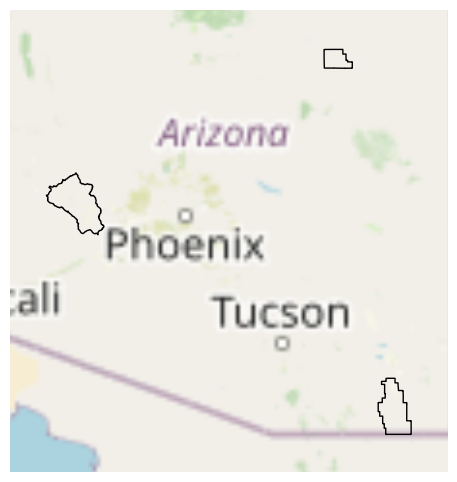

In [15]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru2 = dfru2[dfru2['Geometry'] != ""].reset_index(drop=True)
dfru2['Geometry'] = gpd.GeoSeries.from_wkt(dfru2['Geometry'], crs="EPSG:4326")
gdfru2 = gpd.GeoDataFrame(dfru2, geometry=dfru2['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru2, ax=ax)

In [16]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs2 = dfs.copy()
nameOfWaterSourceTypeCV= "Groundwater" # change here for WaterSourceTypeCV of interest
dfs2 = dfs2[dfs2['WaterSourceTypeCV'] == nameOfWaterSourceTypeCV]
dfs2 = dfs2[dfs2['PODorPOUSite'] == 'POD']
print(len(dfs2))
print(dfs2['WaterSourceTypeCV'].unique())
dfs2.head(1)

123976
['Groundwater']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,AZwr_SPODA01001001BAB,NaN,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,NaN,NaN,NaN,NaN,33.46482,-112.21531,NaN,NaN,POD,WaDE Blank,PODA01001001BAB,NaN,Well,AZ,NaN,AZwr_WSwadeID1,Groundwater


<GeoAxesSubplot: >

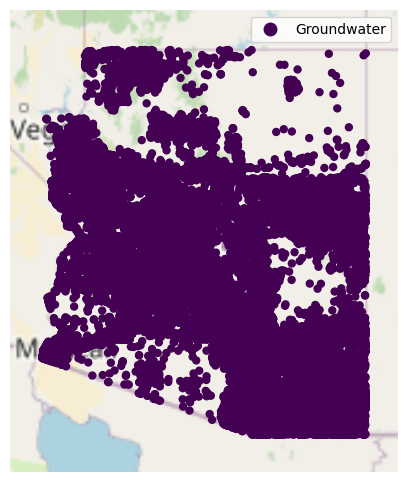

In [17]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs2 = gpd.GeoDataFrame(dfs2, geometry=gpd.points_from_xy(dfs2.Longitude.astype(float), dfs2.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [18]:
# Select sites within polygon.
gdfs2_ru2 = gpd.sjoin(left_df=gdfs2, right_df=gdfru2[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs2_ru2))
gdfs2_ru2.head()

3201


C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
44972,AZwr_SPODA17018001DAA,,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Navajo,4326,,,,,34.90010,-110.37890,,,POD,WaDE Blank,PODA17018001DAA,,Well,AZ,,AZwr_WSwadeID1,Groundwater,POINT (-110.37890 34.90010),1,AZre_RUaz4,AZre_ROaz4
44975,AZwr_SPODA17018003DAD,,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Navajo,4326,,,,,34.89773,-110.41464,,,POD,WaDE Blank,PODA17018003DAD,,Well,AZ,,AZwr_WSwadeID1,Groundwater,POINT (-110.41464 34.89773),1,AZre_RUaz4,AZre_ROaz4
44977,AZwr_SPODA17018009CDD,,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Navajo,4326,,,,,34.88017,-110.43972,,,POD,WaDE Blank,PODA17018009CDD,,Well,AZ,,AZwr_WSwadeID1,Groundwater,POINT (-110.43972 34.88017),1,AZre_RUaz4,AZre_ROaz4
44978,AZwr_SPODA17018009DCC,,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Navajo,4326,,,,,34.88009,-110.43763,,,POD,WaDE Blank,PODA17018009DCC,,Well,AZ,,AZwr_WSwadeID1,Groundwater,POINT (-110.43763 34.88009),1,AZre_RUaz4,AZre_ROaz4
44979,AZwr_SPODA17018009DCD,,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Navajo,4326,,,,,34.88001,-110.43554,,,POD,WaDE Blank,PODA17018009DCD,,Well,AZ,,AZwr_WSwadeID1,Groundwater,POINT (-110.43554 34.88001),1,AZre_RUaz4,AZre_ROaz4


<GeoAxesSubplot: >

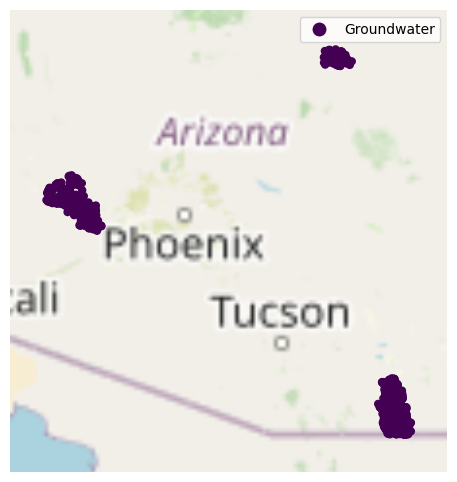

In [19]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs2_ru2, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [20]:
# set RegulatoryOverlayUUIDs
gdfs2_ru2['RegulatoryOverlayUUIDs'] = gdfs2_ru2['RegulatoryOverlayUUID']
gdfs2_ru2 = gdfs2_ru2.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs2_ru2.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
44972,AZwr_SPODA17018001DAA,AZre_ROaz4,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Navajo,4326,,,,,34.90010,-110.37890,,,POD,WaDE Blank,PODA17018001DAA,,Well,AZ,


## Concatenate all Regulatory Area Data Types together
- drop geometry from the wade wr sites.csv geodataframe

In [21]:
# Concatenate dataframes into single output
frames = [dfs, gdfs1_ru1, gdfs2_ru2] # list all out dataframes here
outdfs = pd.concat(frames)
outdfs = outdfs.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
outdfs = outdfs.groupby('SiteUUID').agg(lambda x: ','.join([str(elem) for elem in (list(set(x))) if elem != ""])).replace(np.nan, "").reset_index()
print(len(outdfs))
outdfs.head(1)

192202


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,AZwr_SPODA01001001BAB,AZre_ROaz5,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,,,,,33.464821819000065,-112.21531226699994,,,POD,WaDE Blank,PODA01001001BAB,,Well,AZ,,AZwr_WSwadeID1,Groundwater


# Inspect Output Data & Export

In [22]:
outdfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192202 entries, 0 to 192201
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   SiteUUID                192202 non-null  object
 1   RegulatoryOverlayUUIDs  192202 non-null  object
 2   WaterSourceUUIDs        192202 non-null  object
 3   CoordinateAccuracy      192202 non-null  object
 4   CoordinateMethodCV      192202 non-null  object
 5   County                  192202 non-null  object
 6   EPSGCodeCV              192202 non-null  object
 7   Geometry                192202 non-null  object
 8   GNISCodeCV              192202 non-null  object
 9   HUC12                   192202 non-null  object
 10  HUC8                    192202 non-null  object
 11  Latitude                192202 non-null  object
 12  Longitude               192202 non-null  object
 13  NHDNetworkStatusCV      192202 non-null  object
 14  NHDProductCV            192202 non-n

In [23]:
outdfs

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,AZwr_SPODA01001001BAB,AZre_ROaz5,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,,,,,33.464821819000065,-112.21531226699994,,,POD,WaDE Blank,PODA01001001BAB,,Well,AZ,,AZwr_WSwadeID1,Groundwater
1,AZwr_SPODA01001001BCB,AZre_ROaz5,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,,,,,33.461270187000025,-112.21971850299995,,,POD,WaDE Blank,PODA01001001BCB,,Well,AZ,,AZwr_WSwadeID1,Groundwater
2,AZwr_SPODA01001001BDC,AZre_ROaz5,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,,,,,33.45953603900006,-112.21538376199996,,,POD,WaDE Blank,PODA01001001BDC,,Well,AZ,,AZwr_WSwadeID1,Groundwater
3,AZwr_SPODA01001001CAA,AZre_ROaz5,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,,,,,33.45778043200005,-112.21322774999996,,,POD,WaDE Blank,PODA01001001CAA,,Well,AZ,,AZwr_WSwadeID1,Groundwater
4,AZwr_SPODA01001001CBB,AZre_ROaz5,AZwr_WSwadeID1,WaDE Blank,WaDE Blank,Maricopa,4326,,,,,33.45777930400004,-112.21977613599996,,,POD,WaDE Blank,PODA01001001CBB,,Well,AZ,,AZwr_WSwadeID1,Groundwater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192197,AZwr_SPOUD24032004CB0,,AZwr_WSwadeID4096,WaDE Blank,WaDE Blank,Cochise,4326,,,,,31.369468383305765,-109.09674528535508,,,POU,WaDE Blank,POUD24032004CB0,,WaDE Blank,AZ,,AZwr_WSwadeID4096,Surface Water
192198,AZwr_SPOUD24032004CC0,,AZwr_WSwadeID6486,WaDE Blank,WaDE Blank,Cochise,4326,,,,,31.365875882556868,-109.09673623722612,,,POU,WaDE Blank,POUD24032004CC0,,WaDE Blank,AZ,,AZwr_WSwadeID6486,Surface Water
192199,AZwr_SPOUD24032017AB0,,AZwr_WSwadeID5777,WaDE Blank,WaDE Blank,Cochise,4326,,,,,31.347644755495377,-109.10505480722252,,,POU,WaDE Blank,POUD24032017AB0,,WaDE Blank,AZ,,AZwr_WSwadeID5777,Surface Water
192200,AZwr_SPOUD24032018CC0,,AZwr_WSwadeID2449,WaDE Blank,WaDE Blank,Cochise,4326,,,,,31.33685005484909,-109.13030329208902,,,POU,WaDE Blank,POUD24032018CC0,,WaDE Blank,AZ,,AZwr_WSwadeID2449,Surface Water


In [24]:
# Export out to CSV.
outdfs.to_csv('ProcessedInputData/sites.csv', index=False) # this is in the Regulatory data folder